# <center>Análisis Sentimental (Reviews de videojuegos) - Proyecto IE</center>


|  |  |  |
| --- | --- | --- |
| <img src="https://iaarhub.github.io/images/Inteligencia-Artificial-Deep-Learning.jpg"> | <img src="https://store.akamai.steamstatic.com/public/images/promo/reviews/feature_write.jpg"> |  |





En este Notebook trabajaremos sobre el Data set de **Steam reviews** que comentamos en la presentación. Este dataset cuenta con **6,4 millones de reviews** sobre videojuegos de steam escritas por los usuarios, entre ellas hay reviews positivas y reviews negativas.
El objetivo es entrenar un modelo a partir de este gran número de datos, y conseguir que sea capaz de hacer un **análisis sentimental**, es decir, que si nosotros le escribimos una nueva review, sea capaz de predecir si la review es positiva o negativa, con un % de error bajo. Este Notebook constará de los siguientes puntos:

#### 1. Lectura de los datos
    1.1 Eliminar valores ausentes
#### 2. Análisis exploratorio de datos (EDA)
    2.1 Equilibrio de datos (sobremuestreo)
    2.2 Histogramas
#### 3. Preprocesamiento de Datos
    3.1 Tokenización y Stemming
    3.2 Wordclouds
    
#### 4. Construcción del modelo
    4.1 Conjunto de entrenamiento y conjunto de prueba
    4.2 Entrenamos el modelo
    4.3 Probamos el modelo

## 1. Lectura de los datos

Empezaremos importando los paquetes necesarios, cargando el fichero .csv y leyendo los datos.

In [77]:
#Importamos las librerías necesarias
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import nltk
import seaborn as sns

In [78]:
#Mostramos las primeras filas del dataset
df_reviews = pd.read_csv('steam_reviews.csv')
df_reviews.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [80]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 244.8+ MB


In [81]:
#Mostramos los 15 primeros juegos con más reviews
df_reviews = df_reviews.drop_duplicates(keep='first')

top_reviews_count = pd.value_counts(df_reviews.app_name)[:15].to_frame('count').reset_index()
top_games = top_reviews_count['index'].values
top_games 

#coge solo las mejores reviews de juegos de reviews_ds
top_reviews = df_reviews[df_reviews['app_name'].isin(top_games)] #

top_reviews_count

,index,count
0,Terraria,78276
1,PAYDAY 2,63577
2,Dota 2,50190
3,Undertale,48512
4,Warframe,44970
5,Rocket League,39035
6,Left 4 Dead 2,35406
7,Grand Theft Auto V,30213
8,Arma 3,29854
9,BioShock Infinite,29770


## 1.1 Eliminar valores ausentes

Ahora comprobaremos qué campos del dataset contienen datos ausentes, para así poder eliminarlos ya que no nos aportan ningún tipo de información

In [82]:
print(df_reviews.isnull().any(axis=0)) #Las columnas con True significan que hay valores ausentes

app_id          False
app_name         True
review_text      True
review_score    False
review_votes    False
dtype: bool


In [83]:
df_reviews = df_reviews[['review_score','review_text']] #Usaremos solo estas dos columnas, el resto no nos interesa
df_reviews.dropna(inplace = True)

df_reviews = df_reviews.sample(n = 50000) #Cogemos solo una muestra de 20000 Aleatoria, porque no puedo analziar todo

print(df_reviews.isnull().any(axis=0)) #Las columnas con True significan que hay valores ausentes

print(" ")
df_reviews.info()
df_reviews.reset_index(drop = True, inplace = True)

review_score    False
review_text     False
dtype: bool
 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 2421293 to 2276126
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_score  50000 non-null  int64 
 1   review_text   50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


#### Volvemos a mostrar las primeras filas del dataset:

In [84]:
df_reviews.head()

,review_score,review_text
0,-1,"Pro's: Very pretty, hacking a grenade to blow ..."
1,1,This game is like GTA in the sense that the np...
2,1,ThIS is best game !
3,-1,boring
4,1,"AMAZING, plain n simple...like batman/assasins..."


#### Vemos si hay líneas duplicadas:

In [85]:
df_reviews.duplicated().sum()

374

#### Borramos las líneas duplicadas y vemos que ahora hay 0:

In [86]:
df_reviews.drop_duplicates(inplace=True)
df_reviews.duplicated().sum()

0

## 2. Análisis exploratorio de datos (EDA)

El análisis exploratorio de datos (EDA) se utiliza para analizar e investigar conjuntos de datos y resumir sus características principales, a menudo empleando métodos de visualización de datos. Ayuda a determinar la mejor manera de manipular las fuentes de datos para obtener las respuestas que necesita, lo que facilita descubrir patrones, detectar anomalías, probar hipótesis o verificar suposiciones.

Aquí nos damos cuenta de que hay muchas más reviews positivas que negativas:

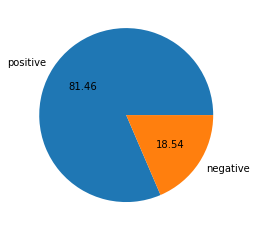

In [87]:
plt.pie(df_reviews['review_score'].value_counts(),labels=['positive','negative'],autopct='%0.2f')
plt.show()

## 2.1 Equilibrio de datos (sobremuestreo)
El hecho de que haya una cantidad desigual de comentarios positivos y negativos puede afectar a la precisión del modelo que vamos a entrenar, por ello vamos a hacer uso de la librería imbalanced-learn para balancearlos:

In [93]:
#Instalamos imblearn: pip install imbalanced-learn

# Sobremuestreo de la clase minoritaria
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
features, labels = ros.fit_resample(df_reviews[['review_text']], df_reviews['review_score'])
df_reviews = pd.concat([pd.DataFrame(features, columns=['review_text']), pd.DataFrame(labels, columns=['review_score'])], axis=1)

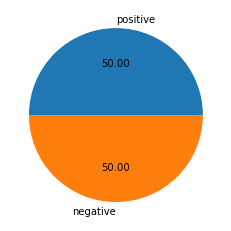

In [94]:
plt.pie(df_reviews['review_score'].value_counts(),labels=['positive','negative'],autopct='%0.2f')
plt.show()

Como podemos ver, ahora las reviews positivas/negativas si están balanceadas

In [95]:
nltk.download('punkt')  

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Javi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2.2 Histogramas
Ahora vamos a crear 3 nuevas columnas (num.caracteres, num.palabras y num.frases) y mediante la biblioteca seaborn vamos a dibujar 3 histogramas para verlas reflejadas respecto a las reseñas positivas (color azul) y las negativas (color rojo):

In [96]:
#Nueva columna con longitud de cada review(num de letras)
df_reviews['num_caracteres'] = df_reviews['review_text'].apply(len)  

#Numero de palabras
df_reviews['num_palabras'] = df_reviews['review_text'].apply(lambda x: len(nltk.word_tokenize(x))) 


#Numero de frases (separado por , o .)
df_reviews['num_frases'] = df_reviews['review_text'].apply(lambda x: len(nltk.sent_tokenize(x)))  

df_reviews.reset_index(drop = True, inplace = True)

df_reviews.head()

,review_text,review_score,num_caracteres,num_palabras,num_frases
0,"Pro's: Very pretty, hacking a grenade to blow ...",-1,437,94,3
1,This game is like GTA in the sense that the np...,1,135,27,1
2,ThIS is best game !,1,19,5,1
3,boring,-1,6,1,1
4,"AMAZING, plain n simple...like batman/assasins...",1,110,22,1


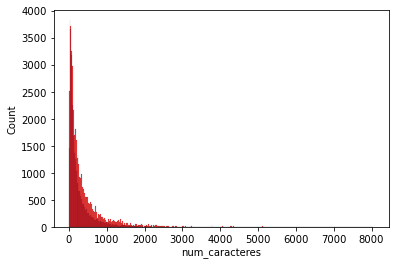

In [107]:
sns.histplot(df_reviews[df_reviews['review_score'] == 1]['num_caracteres'])
sns.histplot(df_reviews[df_reviews['review_score'] == -1]['num_caracteres'],color='red')

plt.show()

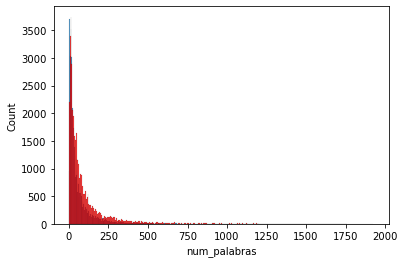

In [108]:
sns.histplot(df_reviews[df_reviews['review_score'] == 1]['num_palabras'])
sns.histplot(df_reviews[df_reviews['review_score'] == -1]['num_palabras'],color='red')

plt.show()

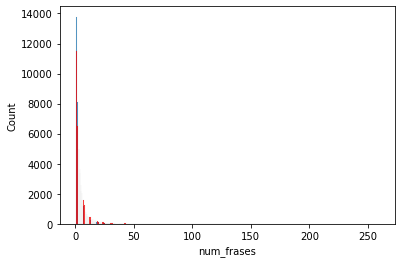

In [109]:
sns.histplot(df_reviews[df_reviews['review_score'] == 1]['num_frases'])
sns.histplot(df_reviews[df_reviews['review_score'] == -1]['num_frases'],color='red')

plt.show()

## 3. Preprocesamiento de Datos

Ahora realizaremos las preparaciones básicas para el preprocesamiento del texto de las reseñas, eliminaremos índices innecesarios, las "stopwords" (palabras que no tienen un significado de manera individual) y los signos de puntuación:

In [111]:
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

## 3.1 Tokenización y Stemming

Una vez importado todo lo necesario, convertimos el texto a minúsculas y lo dividimos en palabras individuales, para posteriormente **tokenizar** el texto y aplicar el stemming a cada token indivdualmente para normalizar el vocabulario y reducir el rudio en los datos del texto.

**- Tokenización:** proceso de dividir un texto en unidades más pequeñas llamadas tokens.

**- Stemming:** proceso de reducir una palabra a su raíz, eliminando sufijos y prefijos, con el objetivo de que las variantes de una misma palabra se reduzcan a una forma base común.

Mientras que la tokenización se centra en dividir el texto en unidades significativas, el stemming se centra en normalizar las palabras individuales para reducir la variabilidad del vocabulario.


In [119]:
nltk.download('stopwords')

def convert_text(text):
    text = text.lower() #para convertir el texto a minúsculas
    text = nltk.word_tokenize(text) #dividimos el texto en palabras individuales
    
#Eliminamos las stopwords y los singnos de puntuación comparando las palabras con la lista de stopwords y signos de puntuación
#si la palabra no está en ninguna de las dos listas, se agrega una nueva lista llamada x
    x = []
    y =[]
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            x.append(i)
    for i in x:
        y.append(ps.stem(i))
    return ' '.join(y)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Javi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [122]:
df_reviews['review_text'][8]

'Once I got the game to work on windows 7, it was pretty sweet!'

👇**CUIDADO CON ESTA CASILLA DE CÓDIGO**👇 Tarda **MUCHO** en ejecutarse

In [123]:
df_reviews['converted_text']=df_reviews['review_text'].apply(convert_text)
df_reviews.head()

,review_text,review_score,num_caracteres,num_palabras,num_frases,converted_text
0,"Pro's: Very pretty, hacking a grenade to blow ...",-1,437,94,3,pro 's pretti hack grenad blow enemi two n't g...
1,This game is like GTA in the sense that the np...,1,135,27,1,game like gta sens npc open world charecterist...
2,ThIS is best game !,1,19,5,1,best game
3,boring,-1,6,1,1,bore
4,"AMAZING, plain n simple...like batman/assasins...",1,110,22,1,amaz plain n simpl ... like batman/assasin cre...


#### 👆Aquí visualizamos el texto original de las reviews junto con su texto transformado tras haber realizado la tokenización y stemming👆

## 3.2 Wordclouds
Ahora mediante una "nube de palabras" vamos a visualizar cuales son las palabras más comunes en las reseñas positivas, el tamaño de la palabra representa su frecuencia relativa en el texto:

In [74]:
#pip install wordcloud
from wordcloud import WordCloud
wc = WordCloud(
            background_color = 'black',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            )

In [75]:
pos_wc = wc.generate(df_reviews[df_reviews['review_score']==1]['converted_text'].str.cat(sep=" "))
plt.imshow(pos_wc)
plt.show()

ValueError: Only supported for TrueType fonts

#### Ahora volvemos a hacer lo mismo pero con las reseñas negativas:

In [ ]:
neg_wc = wc.generate(df_reviews[df_reviews['review_score']==-1]['converted_text'].str.cat(sep=" "))
plt.imshow(neg_wc)
plt.show()

## 4. Construcción del modelo

Para entrenar el modelo vamos a convertir el texto en vectores de características, para ello seleccionamos las 3000 palabras más frecuentes en el corpus (textos que se utilizan como fuente de datos en el entrenamiento del modelo) para ser consideradas como características:

In [124]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer(max_features = 3000) #seleccionamos las 3000 palabras mas frecuentes en el corpus
tfidf = TfidfVectorizer(max_features=5000)

#### Vemos que hay tantas filas como reseñas en el corpus y tantas columnas como características

In [125]:
#Transformamos la columna de reviews convertidas en una matriz de características "X"
X = cv.fit_transform(df_reviews['converted_text']).toarray()
X.shape

(80846, 3000)

#### Aquí vemos las etiquetas  de clasificación de cada review (1 positiva, -1 negativa):

In [126]:
y = df_reviews['review_score'].values
y

array([-1,  1,  1, ..., -1, -1, -1], dtype=int64)

## 4.1 Conjunto de entrenamiento y conjunto de prueba

Dividimos los datos en un conjunto de entrenamiento (X_train y Y_train) y un conjunto de prueba (X_test y Y_test). 
- X es la matriz de características que contiene las revisiones convertidas en vectores numéricos. 
- Y es la matriz de etiquetas que contiene los valores objetivo (positivos o negativos) de las reviews.

Con train_test_split dividimos aleatoriamente los datos en conjuntos de entrenamiento y prueba, utilizando un 20% para la prueba. Con el parámetro random_state garantizamos la reproducibilidad del experimento, es decir, que los mismos datos se dividan en los mismos conjuntos de entrenamiento y prueba en cada ejecución del código. 

In [128]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 34)

print('X_train shape : ', X_train.shape)
print('y_train shape: ', y_train.shape)

print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape :  (64676, 3000)
y_train shape:  (64676,)
X_test shape:  (16170, 3000)
y_test shape:  (16170,)


## 4.2 Entrenamos el modelo
Ahora entrenamos tres modelos de clasificación Naive Bayes, los cuales son:

- **GaussianNB**: asume que las características siguen una distribución normal.
- **MultinomialNB**: se utiliza cuando las características tienen valores discretos como en el caso de frecuencia de palabras en un documento.
- **BernoulliNB**: se utiliza para características booleanas.

In [129]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

Ahora ajustamos el modelo GaussianNB con los datos de entrenamiento (X_train, Y_train), predecimos las clases con el conjunto de datos de prueba (X_test), e imprimimos la precisión, exactitud y matriz de confusión del modelo:

In [130]:
gnb.fit(X_train,y_train)#ajustamos el modelo con los datos de entrenamiento
y_pred1 = gnb.predict(X_test)#predecimos las clases con el conjunto de prueba
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.6444032158317873
[[3445 4669]
 [1081 6975]]
0.5990209549982823


#### Aquí hacemos lo mismo pero con el modelo MultinomialNB:

In [131]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))


0.8183673469387756
[[6610 1504]
 [1433 6623]]
0.8149378614494893


#### Y aquí con el BernoulliNB:

In [132]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.6615337043908472
[[3961 4153]
 [1320 6736]]
0.6186059325925246


## 4.3 Probamos el modelo
Observamos que los mejores resultados los obtenemos con el modeloc **MultinomialNB**, ahora vamos a probar el modelo con una review que nosotros nos inventemos:

In [133]:
def checker(text):
    test = convert_text(text)
    X = cv.transform([test])
    response = mnb.predict(X)[0]
    if response ==  1:
        return 'Positive Review'
    else:
        return 'Negative Review'

In [153]:
print("----------------------------------------------------------")
print("Review: I recently purchased and played 'XYZ Game' and unfortunately, I was very disappointed with my experience. From the very beginning, the game failed to captivate me. The storyline was unoriginal and predictable, and the graphics were outdated and dull. The gameplay was clunky and unresponsive, with frustratingly long load times and frequent glitches that interrupted the flow of the game. The controls were confusing and difficult to master, making even the simplest tasks a chore. To make matters worse, the game was riddled with microtransactions and pay-to-win mechanics, which made it feel like a cash grab rather than a genuine attempt to create an enjoyable gaming experience. Overall, I found 'XYZ Game' to be a complete waste of my time and money. I would not recommend this game to anyone, and I regret purchasing it. Save your money and look for a better game to play.")
print("")
print("Prediction: "+ checker('I recently purchased and played "XYZ Game" and unfortunately, I was very disappointed with my experience. From the very beginning, the game failed to captivate me. The storyline was unoriginal and predictable, and the graphics were outdated and dull. The gameplay was clunky and unresponsive, with frustratingly long load times and frequent glitches that interrupted the flow of the game. The controls were confusing and difficult to master, making even the simplest tasks a chore. To make matters worse, the game was riddled with microtransactions and pay-to-win mechanics, which made it feel like a cash grab rather than a genuine attempt to create an enjoyable gaming experience. Overall, I found "XYZ Game" to be a complete waste of my time and money. I would not recommend this game to anyone, and I regret purchasing it. Save your money and look for a better game to play.'))

print("")
print("----------------------------------------------------------")
print("")

print("Review: This is the best game I've ever played, my neighbor recommended it to me and I can't stop playing it ever since.")
print("")
print("Prediction: "+ checker("This is the best game I've ever played, my neighbor recommended it to me and I can't stop playing it ever since."))

print("")
print("----------------------------------------------------------")
print("")

print("Review: Since I played this truck simulator my life changed, now I know that when I grow up I want to work driving trucks.")
print("")
print("Prediction: "+ checker("Since I played this truck simulator my life changed, now I know that when I grow up I want to work driving trucks."))
print("----------------------------------------------------------")

print ("Review: I thought it was fun at first but from the middle of the game it started to get very long and repetitive.")
print("")
print("Prediction: "+ checker("I thought it was fun at first but from the middle of the game it started to get very long and repetitive."))

print("")
print("----------------------------------------------------------")
print("")

print("Review: It has been a very difficult game to understand and therefore I have been bored.")
print("")
print("Prediction: "+ checker("It has been a very difficult game to understand and therefore I have been bored."))

----------------------------------------------------------
Review: I recently purchased and played 'XYZ Game' and unfortunately, I was very disappointed with my experience. From the very beginning, the game failed to captivate me. The storyline was unoriginal and predictable, and the graphics were outdated and dull. The gameplay was clunky and unresponsive, with frustratingly long load times and frequent glitches that interrupted the flow of the game. The controls were confusing and difficult to master, making even the simplest tasks a chore. To make matters worse, the game was riddled with microtransactions and pay-to-win mechanics, which made it feel like a cash grab rather than a genuine attempt to create an enjoyable gaming experience. Overall, I found 'XYZ Game' to be a complete waste of my time and money. I would not recommend this game to anyone, and I regret purchasing it. Save your money and look for a better game to play.

Prediction: Negative Review

------------------------